## CSCI S-89 Introduction to Deep Learning
Harvard Summer School 2025

# Final Project:
# *Face Recognition with Deep Learning*

The goal of this project is to detect human faces in images and recognize who the faces belong to from a predefined group of people.

# Part II: **Inspect, Clean, and Preprocess Input Data**

Let's take a look at Kaggle's Face Recognition Dataset and see whether we need to do any preprocessing or cleaning of the data.

In [ ]:
from google.colab import drive

# Mount Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the path of the working directory.
project_path = '/content/drive/MyDrive/CSCI S-89 Deep Learning/FinalProject'

In [ ]:
import zipfile

RUN_ONLY_ONCE = False

if RUN_ONLY_ONCE:
  # I uploaded the input dataset to Google Drive as a zip file,
  # so first I need to unzip it.
  zip_path = os.path.join(project_path, 'face_recognition_dataset.zip')
  extract_path = os.path.join(project_path, 'face_recognition_dataset')

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

In [ ]:
import os

# Get the path to the images.
images_path = os.path.join(project_path, 'face_recognition_dataset', 'peoples_faces', 'peoples_faces')

In [ ]:
# Get all the people in the dataset.
# Each person has their own folder with their face images.
people = os.listdir(images_path)

# Count the number of images for each person.
person_img_count = {}

for person in people:
  person_folder = os.path.join(images_path, person)
  person_img_count[person] = len(os.listdir(person_folder))

In [ ]:
print(f'In the dataset we have {len(people)} people.')

In the dataset we have 31 people.


In [ ]:
for person in person_img_count:
  print(f'{person} has {person_img_count[person]} images.')

Akshay Kumar has 50 images.
Alexandra Daddario has 92 images.
Alia Bhatt has 79 images.
Amitabh Bachchan has 74 images.
Andy Samberg has 92 images.
Anushka Sharma has 68 images.
Billie Eilish has 98 images.
Brad Pitt has 120 images.
Camila Cabello has 87 images.
Charlize Theron has 78 images.
Claire Holt has 96 images.
Courtney Cox has 80 images.
Dwayne Johnson has 61 images.
Elizabeth Olsen has 71 images.
Ellen Degeneres has 75 images.
Henry Cavill has 106 images.
Hrithik Roshan has 101 images.
Hugh Jackman has 112 images.
Jessica Alba has 108 images.
Kashyap has 30 images.
Lisa Kudrow has 70 images.
Margot Robbie has 72 images.
Marmik has 32 images.
Natalie Portman has 105 images.
Priyanka Chopra has 102 images.
Robert Downey Jr has 113 images.
Roger Federer has 77 images.
Tom Cruise has 58 images.
Vijay Deverakonda has 115 images.
Virat Kohli has 49 images.
Zac Efron has 91 images.


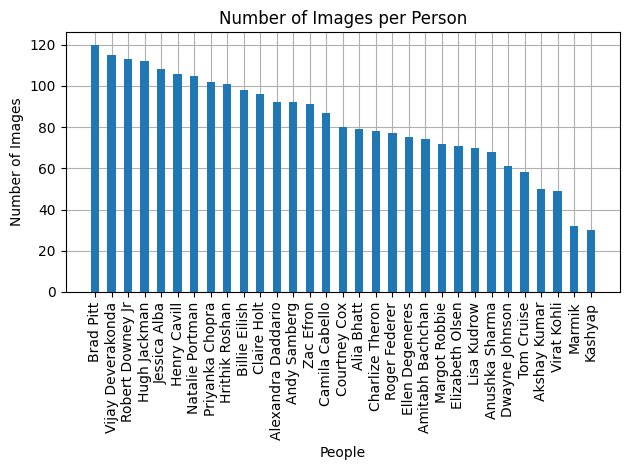

In [ ]:
import matplotlib.pyplot as plt

# Plot a bar chart to visualize how many images we have per person.

# Sort person_img_count dictionary by number of images (descending order).
sorted_person_img_count = dict(sorted(person_img_count.items(), key=lambda item: item[1], reverse=True))

plt.bar(sorted_person_img_count.keys(), sorted_person_img_count.values(), width=0.5, zorder=3)
plt.title('Number of Images per Person')
plt.xticks(rotation=90)
plt.xlabel('People')
plt.ylabel('Number of Images')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.show()

In the graph above we see how many face images we have for every person in the Kaggle dataset.

As we can see, the Face Recognition Dataset has 31 people with 30-120 face images each. To have a **balanced** and **fair** input dataset, we want to use the **same number of pictures for every person**. To do this, we will keep only those who have at least 80 pictures, and for those who have more, we will delete the extras.

In [ ]:
import shutil

number_of_images = 80 # Number of images we want for every person.

# For every person in the dataset...
for person, count in person_img_count.items():
  # Take the person's folder.
  persons_folder = os.path.join(images_path, person)

  # If the person has less than 80 images,
  # delete the folder.
  if count < number_of_images:
    shutil.rmtree(persons_folder)
  # If the person has more than 80 images,
  # trim the extra images.
  else:
    # Take all images for person.
    images = sorted(os.listdir(persons_folder))

    # Get the extra images.
    extra_images = images[number_of_images:]

    # Delete extra images.
    for img in extra_images:
      os.remove(os.path.join(persons_folder, img))

Another thing worth mentioning is that not all images in the dataset have the same size. This is both for Kaggle and the images that I collected. In addition, not all images are explicitly face images. In some we see a broader view of the background or the body of the person (noise). Or there is variability in the position where the face appears in the image. To give our model a **cleaner**, **more consistent input**, we should **standardize the image content**. We will detect and crop the faces from all images and resize them to 224x224 pixels. This ensures all images are **aligned** and **uniform**, which improves the quality of the data and help the model **learn and generalize better**.

For face detection we will use **MTCNN** (Multi-task Cascaded Convolutional Neural Network), a pre-trained, deep learning model that detects faces with high accuracy. For the face detection I also tried OpenCV and Haar Cascade Classifier, but it didn't work well.

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN
import numpy as np
from PIL import Image
import cv2

RUN_ONLY_ONCE = False

if RUN_ONLY_ONCE:
  # Load MTCNN face detector.
  face_detector = MTCNN()

  # Define the target image size.
  target_image_size = (224, 224)

  # For every person in the dataset...
  for person in os.listdir(images_path):
    # Take the person's folder.
    persons_folder = os.path.join(images_path, person)

    # For every image in the person's folder...
    for img in os.listdir(persons_folder):
      try:
        # Take the image.
        image_path = os.path.join(persons_folder, img)

        # Prepare image for MTCNN.
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image)

        # Detect face.
        face = face_detector.detect_faces(image_np)

        # Take the face.
        x, y, w, h = face[0]['box']
        x, y = max(0, x), max(0, y)
        face = image_np[y:y+h, x:x+w]

        # Resize the face.
        face_resized = cv2.resize(face, target_image_size)

        # Save the new image.
        cv2.imwrite(image_path, cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))
      except Exception as e:
        continue

This part required a lot of manual work as well. There were result images that contained the wrong face (a face from the background of the initial image for example), or something went wrong and the result image was a blur. So, I had to manually check the result images, replace the problematic initial images with new ones, and rerun the code.